In [1]:
import sys
sys.path.append("..")
sys.path.append("../src/")
sys.path.append("../src/algs/")


from src import interface
from src import simulator
from src import algs


In [18]:
def weight_function_distance(buyer_pos, buyer_d, seller_pos, seller_d):
    bx, by = buyer_pos
    sx, sy = seller_pos
    return 1/(1 + (bx-sx)**2 + (by-sy)**2)

In [19]:
inter = interface.Interface(
    algs.Greedy(),
    simulator.Simulator(weight_function_distance),
    p_node=1,
    seed=42,
    dep_distr=(3,0), # to make d constant for all nodes, make variance 0 (duh)
    verbose=True)

Random seed set to:  42


In [20]:
weights, d_b, d_s = inter.run(100)

Node: (10,7), 3, True
Added a node at step  0
Node: (9,6), 3, False
Added a node at step  1
Node: (10,8), 3, True
Added a node at step  2
Node: (5,4), 3, True
Added a node at step  3
Node: (1,3), 3, False
Added a node at step  4
Node: (5,6), 3, True
Added a node at step  5
Node: (2,1), 3, True
Added a node at step  6
Node: (4,1), 3, True
Added a node at step  7
Node: (9,3), 3, False
Added a node at step  8
Node: (2,10), 3, False
Added a node at step  9
Node: (9,6), 3, True
Added a node at step  10
Node: (4,3), 3, False
Added a node at step  11
Node: (8,1), 3, False
Added a node at step  12
Node: (1,4), 3, True
Added a node at step  13
Node: (6,3), 3, True
Added a node at step  14
Node: (6,9), 3, True
Added a node at step  15
Node: (7,8), 3, True
Added a node at step  16
Node: (4,0), 3, True
Added a node at step  17
Node: (6,3), 3, True
Added a node at step  18
Node: (8,2), 3, True
Added a node at step  19
Node: (2,9), 3, False
Added a node at step  20
Node: (2,9), 3, False
Added a node

In [21]:
weights

[(0.16666666666666666, 3),
 (0.16666666666666666, 6),
 (0.1, 10),
 (0.09090909090909091, 13),
 (0.1111111111111111, 14),
 (0.011627906976744186, 22),
 (0.07142857142857142, 27),
 (0.03333333333333333, 33),
 (0.023809523809523808, 36),
 (0.011627906976744186, 39),
 (0.037037037037037035, 43),
 (0.038461538461538464, 45),
 (0.05555555555555555, 54),
 (0.02857142857142857, 56),
 (0.07142857142857142, 59),
 (0.07142857142857142, 65),
 (0.09090909090909091, 68),
 (0.03333333333333333, 71),
 (0.05555555555555555, 77),
 (0.037037037037037035, 78),
 (0.047619047619047616, 84),
 (0.05555555555555555, 87),
 (0.038461538461538464, 93)]

In [22]:
d_b

[(0, 0),
 (0, 1),
 (1, 2),
 (0, 3),
 (0, 4),
 (1, 5),
 (0, 6),
 (1, 7),
 (0, 8),
 (1, 9),
 (0, 10),
 (0, 11),
 (0, 12),
 (0, 13),
 (0, 14),
 (0, 15),
 (0, 16),
 (1, 17),
 (1, 18),
 (1, 19),
 (1, 20),
 (1, 21),
 (0, 22),
 (0, 23),
 (0, 24),
 (0, 25),
 (1, 26),
 (0, 27),
 (1, 28),
 (0, 29),
 (1, 30),
 (0, 31),
 (0, 32),
 (0, 33),
 (0, 34),
 (1, 35),
 (0, 36),
 (0, 37),
 (1, 38),
 (0, 39),
 (1, 40),
 (0, 41),
 (1, 42),
 (0, 43),
 (0, 44),
 (0, 45),
 (0, 46),
 (0, 47),
 (0, 48),
 (1, 49),
 (0, 50),
 (0, 51),
 (0, 52),
 (0, 53),
 (0, 54),
 (0, 55),
 (0, 56),
 (1, 57),
 (0, 58),
 (0, 59),
 (1, 60),
 (0, 61),
 (1, 62),
 (0, 63),
 (0, 64),
 (0, 65),
 (1, 66),
 (0, 67),
 (0, 68),
 (0, 69),
 (0, 70),
 (0, 71),
 (0, 72),
 (1, 73),
 (0, 74),
 (0, 75),
 (0, 76),
 (0, 77),
 (0, 78),
 (0, 79),
 (0, 80),
 (0, 81),
 (0, 82),
 (1, 83),
 (0, 84),
 (0, 85),
 (0, 86),
 (0, 87),
 (0, 88),
 (0, 89),
 (0, 90),
 (0, 91),
 (0, 92),
 (0, 93),
 (0, 94),
 (0, 95),
 (0, 96),
 (0, 97),
 (0, 98),
 (0, 99)]

In [23]:
d_s

[(0, 0),
 (0, 1),
 (0, 2),
 (0, 3),
 (0, 4),
 (0, 5),
 (0, 6),
 (0, 7),
 (0, 8),
 (0, 9),
 (0, 10),
 (1, 11),
 (0, 12),
 (0, 13),
 (0, 14),
 (0, 15),
 (0, 16),
 (0, 17),
 (0, 18),
 (0, 19),
 (0, 20),
 (0, 21),
 (0, 22),
 (1, 23),
 (0, 24),
 (1, 25),
 (0, 26),
 (0, 27),
 (0, 28),
 (0, 29),
 (0, 30),
 (1, 31),
 (1, 32),
 (0, 33),
 (0, 34),
 (0, 35),
 (0, 36),
 (0, 37),
 (0, 38),
 (0, 39),
 (0, 40),
 (0, 41),
 (0, 42),
 (0, 43),
 (0, 44),
 (0, 45),
 (1, 46),
 (0, 47),
 (1, 48),
 (0, 49),
 (1, 50),
 (1, 51),
 (1, 52),
 (1, 53),
 (0, 54),
 (0, 55),
 (0, 56),
 (0, 57),
 (0, 58),
 (0, 59),
 (0, 60),
 (0, 61),
 (0, 62),
 (1, 63),
 (1, 64),
 (0, 65),
 (0, 66),
 (0, 67),
 (0, 68),
 (0, 69),
 (1, 70),
 (0, 71),
 (0, 72),
 (0, 73),
 (1, 74),
 (1, 75),
 (1, 76),
 (0, 77),
 (0, 78),
 (0, 79),
 (0, 80),
 (1, 81),
 (1, 82),
 (0, 83),
 (0, 84),
 (1, 85),
 (0, 86),
 (0, 87),
 (0, 88),
 (1, 89),
 (1, 90),
 (1, 91),
 (1, 92),
 (0, 93),
 (1, 94),
 (0, 95),
 (1, 96),
 (1, 97),
 (1, 98),
 (1, 99)]

In [26]:
import matplotlib.pyplot as plt

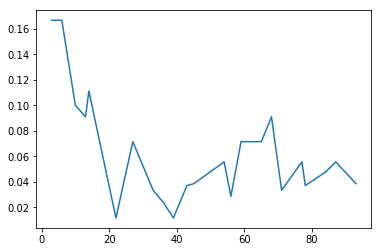

In [30]:
plt.plot([w[1] for w in weights], [w[0] for w in weights])
plt.show()